In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, contact_optimization, show_selected_joints, get_fixed_boundary_joint)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [5]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('owl_1', thickness, width, weaving_dir)

0.033273539253433904 0.0023291477477403733


In [6]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 10;
OPTS.beta = 1e-8
OPTS.niter = 100
OPTS.verboseNonPosDef = False

In [7]:
rw = 1
sw = 10

In [9]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width = True, interleaving_type=elastic_rods.InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [10]:
curved_linkage.setExtendedDoFsPSRL(np.load('../biaxial/results/owl_1/owl_1_dof.npy'))

In [11]:
curved_linkage.attraction_weight = 1e-5

In [12]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [13]:
OPTS.niter = 10000

In [14]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

0	0.00739741	21.8643	21.8643	1	1
10	0.000216163	0.051001	0.051001	1	1
20	2.37192e-05	0.00241601	0.00241601	0.25	0
30	2.13999e-05	9.08562e-05	9.08562e-05	1	0
40	2.13998e-05	5.35934e-06	5.35934e-06	1	0


../../../../elastic_rods/python/structural_analysis.py:213: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


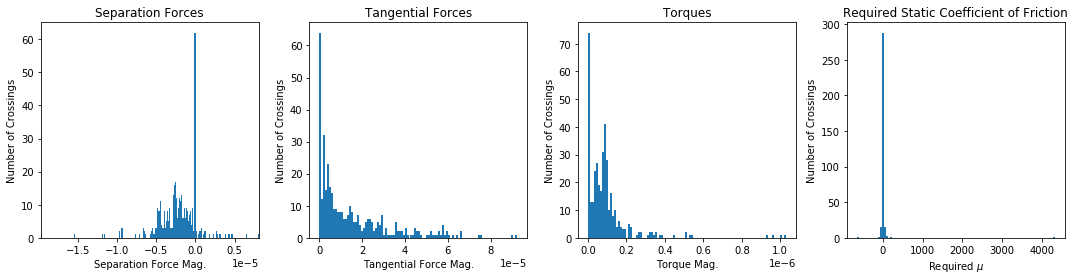

In [15]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [16]:
import structural_analysis

In [17]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)

In [18]:
cfm[:, 0].argsort()[-1]

221

In [19]:
max(cfm[:, 0])

8.065886363227437e-06

### Deactivate Crossing

In [26]:
import deactivate_crossing_helper
importlib.reload(deactivate_crossing_helper)
from deactivate_crossing_helper import (write_deactivated_linkage, copy_over_under, get_segment_index_from_joints, get_angle_from_kappa, get_kappa_from_angle, no_resample_deactivation, resample_deactivation, get_neighbors)

In [36]:
curved_linkage.numJoints()

384

In [37]:
curved_linkage.numSegments()

736

In [31]:
def create_deactivated_linkage(original_linkage, deactive_index, original_model_name, deactivated_model_name):
    ju = original_linkage.joint(deactive_index)
    nbs = ju.neighbors()
    print('neighbors: ', nbs)
    deactive_vertex_map = [i if i < deactive_index else i - 1 for i in range(original_linkage.numJoints())]
    print(len(deactive_vertex_map))
    write_deactivated_linkage(original_model_name, deactivated_model_name, deactive_index, deactive_vertex_map, nbs)
    
    with so(): deactivate_curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = deactivated_model_name, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type=elastic_rods.InterleavingType.weaving)
    deactivate_curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    curved_save_tgt_joint_pos = deactivate_curved_linkage.jointPositions();
    deactivate_curved_linkage.attraction_weight = 1e-5

#     Copy the over under assignment from the original model since BFS will not find a perfect over under in the new topology
    copy_over_under(deactivate_curved_linkage, original_linkage, deactive_vertex_map, deactive_index)
    vf = show_selected_joints(deactivate_curved_linkage, [deactive_vertex_map[12], deactive_vertex_map[258]])
    deactivate_curved_linkage.setDoFs(deactivate_curved_linkage.getDoFs())

    resample_deactivation(deactivate_curved_linkage, original_linkage, deactive_vertex_map, nbs, deactive_index, io)
    return deactivate_curved_linkage, deactive_vertex_map

In [32]:
deactive_index = 221

In [33]:
deactivated_model_name = ('/'.join(io.MODEL_PATH.split('/')[:-1] + [io.MODEL_NAME + '_deactive_joint_{}.obj'.format(deactive_index)]))

In [34]:
deactivate_linkage, deactive_vertex_map = create_deactivated_linkage(curved_linkage, deactive_index, io.MODEL_PATH, deactivated_model_name)

neighbors:  [217, 155, 345, 216]
384
[1, 2]
[2, 3]
[3, 4]
[4, 5]
[5, 6]
[6, 7]
[7, 8]
[8, 9]
[9, 10]
[10, 11]
[12, 13]
[13, 14]
[14, 15]
[15, 6]
[6, 16]
[16, 17]
[17, 18]
[18, 19]
[19, 20]
[20, 21]
[22, 23]
[23, 24]
[24, 25]
[25, 26]
[26, 16]
[16, 27]
[27, 28]
[28, 29]
[29, 30]
[30, 31]
[32, 33]
[33, 34]
[34, 35]
[35, 36]
[36, 27]
[27, 5]
[5, 37]
[37, 38]
[38, 39]
[39, 40]
[41, 42]
[42, 43]
[43, 44]
[44, 45]
[45, 46]
[46, 47]
[47, 37]
[37, 15]
[15, 48]
[48, 49]
[49, 50]
[51, 52]
[52, 53]
[53, 54]
[54, 55]
[55, 56]
[56, 57]
[57, 58]
[58, 17]
[17, 36]
[36, 59]
[59, 60]
[60, 61]
[61, 62]
[63, 64]
[64, 59]
[59, 28]
[28, 4]
[4, 47]
[47, 65]
[65, 66]
[66, 67]
[67, 68]
[68, 42]
[42, 69]
[70, 71]
[71, 72]
[72, 48]
[48, 7]
[7, 26]
[26, 58]
[58, 73]
[73, 74]
[74, 75]
[75, 76]
[76, 77]
[77, 78]
[78, 79]
[80, 81]
[81, 82]
[82, 83]
[83, 84]
[85, 86]
[86, 87]
[87, 88]
[88, 89]
[89, 90]
[90, 91]
[91, 81]
[81, 92]
[92, 93]
[93, 60]
[60, 29]
[29, 3]
[3, 46]
[46, 65]
[65, 38]
[38, 14]
[14, 72]
[72, 94]


IndexError: list index out of range

In [25]:
deactivate_curved_linkage_view = linkage_vis.LinkageViewer(deactivate_linkage)
deactivate_curved_linkage_view.show()

NameError: name 'deactivate_linkage' is not defined

In [39]:
topColor =[150/255., 150/255., 150/255.]
bottomColor =[79/255., 158/255., 246/255.]
heights = deactivate_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [40]:
deactivate_curved_linkage_view.update(scalarField = colors)

In [28]:
deactivate_fixed_boundary_joints = get_fixed_boundary_joint(deactivate_linkage)

In [42]:
def eqm_callback(prob, i):
    deactivate_curved_linkage_view.update()

In [43]:
elastic_rods.compute_equilibrium(deactivate_linkage, callback = eqm_callback, options = OPTS, fixedVars = deactivate_fixed_boundary_joints)

0	0.00217072	0.408541	0.408541	1	1
10	0.00114897	0.0248146	0.0248146	1	1
20	0.00091358	0.0170254	0.0170254	1	1
30	0.000581815	0.00958344	0.00958344	1	1
40	0.00026372	0.00925474	0.00925474	1	1
50	0.000107868	0.00472955	0.00472955	1	1
60	5.43669e-05	0.00113617	0.00113617	1	1
70	1.13752e-05	0.000389133	0.000389133	1	1
80	2.56312e-06	3.44462e-05	3.44462e-05	1	1
90	8.18196e-07	0.000159091	0.000159091	1	0


In [41]:
vf = show_selected_joints(deactivate_linkage, [deactive_vertex_map[302], deactive_vertex_map[301], deactive_vertex_map[129], deactive_vertex_map[131]])
deactivate_curved_linkage_view.update(vectorField = vf, scalarField = colors)